In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import seaborn as sns
from typing import Optional, List, Union

class SWBVisualizer:
    """Visualization tools for SWB model NetCDF output"""

    def __init__(self, data_dir: Union[str, Path]):
        """Initialize visualizer with data directory

        Args:
            data_dir: Directory containing NetCDF output files
        """
        self.data_dir = Path(data_dir)
        if not self.data_dir.exists():
            raise FileNotFoundError(f"Data directory not found: {self.data_dir}")

    def load_data(self, filename: str) -> xr.Dataset:
        """Load a NetCDF file

        Args:
            filename: Name of NetCDF file

        Returns:
            xarray Dataset containing the data
        """
        path = self.data_dir / filename
        return xr.open_dataset(path)

    def plot_variable(self, ds: xr.Dataset, variable: str,
                     time_index: int = 0, cmap: str = 'viridis',
                     title: Optional[str] = None, figsize: tuple = (10, 8)) -> None:
        """Plot a single variable at a specific time

        Args:
            ds: xarray Dataset
            variable: Name of variable to plot
            time_index: Time index to plot (default 0)
            cmap: Colormap to use
            title: Optional title for plot
            figsize: Figure size (width, height)
        """
        plt.figure(figsize=figsize)

        # Extract data and mask no-data values
        data = ds[variable][time_index].values
        mask = data == ds[variable]._FillValue
        data = np.ma.masked_array(data, mask)

        # Create plot
        im = plt.imshow(data, cmap=cmap)
        plt.colorbar(im, label=f"{variable} ({ds[variable].units})")

        # Add title
        if title is None:
            title = f"{variable} - {ds.time.values[time_index]}"
        plt.title(title)

        plt.axis('scaled')
        plt.show()

    def plot_timeseries(self, ds: xr.Dataset, variable: str,
                       row: int, col: int, figsize: tuple = (12, 6)) -> None:
        """Plot timeseries for a specific grid cell

        Args:
            ds: xarray Dataset
            variable: Name of variable to plot
            row: Grid row index
            col: Grid column index
            figsize: Figure size (width, height)
        """
        plt.figure(figsize=figsize)

        # Extract timeseries data
        data = ds[variable].isel(y=row, x=col)

        # Create plot
        plt.plot(ds.time, data, '-o')
        plt.xlabel('Date')
        plt.ylabel(f"{variable} ({ds[variable].units})")
        plt.title(f"{variable} at Grid Cell ({row}, {col})")
        plt.grid(True)

        # Rotate x-axis labels for better readability
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def plot_variable_stats(self, ds: xr.Dataset, variable: str,
                          figsize: tuple = (12, 6)) -> None:
        """Plot statistical summary of a variable over time

        Args:
            ds: xarray Dataset
            variable: Name of variable to plot
            figsize: Figure size (width, height)
        """
        plt.figure(figsize=figsize)

        # Calculate statistics
        mean = ds[variable].mean(dim=['y', 'x'])
        std = ds[variable].std(dim=['y', 'x'])

        # Create plot
        plt.plot(ds.time, mean, 'b-', label='Mean')
        plt.fill_between(ds.time, mean - std, mean + std,
                        color='b', alpha=0.2, label='±1 Std Dev')

        plt.xlabel('Date')
        plt.ylabel(f"{variable} ({ds[variable].units})")
        plt.title(f"Domain-averaged {variable} with Uncertainty")
        plt.grid(True)
        plt.legend()

        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def plot_water_balance(self, ds: xr.Dataset, time_index: int = -1,
                          figsize: tuple = (12, 8)) -> None:
        """Plot water balance components

        Args:
            ds: xarray Dataset
            time_index: Time index to plot (default -1 for latest)
            figsize: Figure size (width, height)
        """
        water_vars = ['rainfall', 'actual_et', 'runoff', 'net_infiltration']

        fig, axes = plt.subplots(2, 2, figsize=figsize)
        axes = axes.ravel()

        for i, var in enumerate(water_vars):
            if var in ds:
                data = ds[var][time_index].values
                mask = data == ds[var]._FillValue
                data = np.ma.masked_array(data, mask)

                im = axes[i].imshow(data, cmap='Blues')
                plt.colorbar(im, ax=axes[i], label=f"{var} ({ds[var].units})")
                axes[i].set_title(var)
                axes[i].axis('scaled')

        plt.suptitle(f"Water Balance Components - {ds.time.values[time_index]}")
        plt.tight_layout()
        plt.show()



In [6]:
# Initialize visualizer
vis = SWBVisualizer(r'C:\Users\paulinkenbrandt\Documents\GitHub\pySWB2\output')

# Load data
ds = vis.load_data('gross_precipitation.nc')
variable = 'gross_precipitation'
# Plot various visualizations
vis.plot_variable(ds, variable)
vis.plot_timeseries(ds, variable, row=10, col=10)
vis.plot_variable_stats(ds, variable)
vis.plot_water_balance(ds)

AttributeError: 'DataArray' object has no attribute '_FillValue'

<Figure size 1000x800 with 0 Axes>

In [9]:
import xarray as xr

# Load the NetCDF file to inspect its structure and contents
file_path_rainfall = '../output/rainfall.nc'
rainfall_data = xr.open_dataset(file_path_rainfall)

# Display the dataset's structure and variables
rainfall_data


<xarray.Dataset> Size: 194MB
Dimensions:   (x: 316, y: 210, time: 730)
Coordinates:
  * x         (x) float64 3kB 7.398e+05 7.401e+05 ... 8.185e+05 8.188e+05
  * y         (y) float64 2kB 2.277e+06 2.277e+06 ... 2.329e+06 2.329e+06
  * time      (time) datetime64[ns] 6kB 2001-01-01 2001-01-02 ... 2002-12-31
Data variables:
    rainfall  (time, y, x) float32 194MB ...
Attributes:
    description:    SWB Model Output - rainfall
    history:        Created 2024-12-08 09:52:42
    source:         pySWB2 Model
    proj4:          +proj=utm +zone=4 +ellps=WGS84 +datum=WGS84 +units=m +no_...
    model_version:  2.0
    start_date:     2001-01-01
    end_date:       2002-12-31

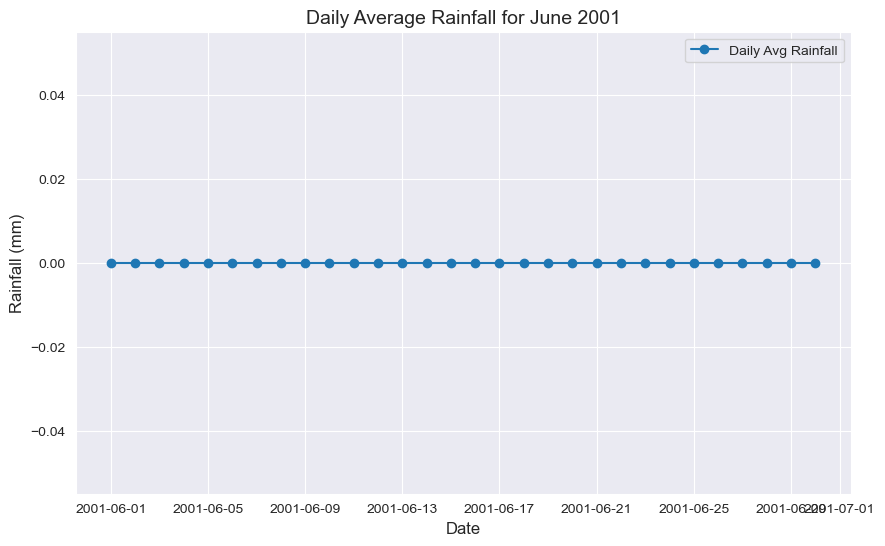

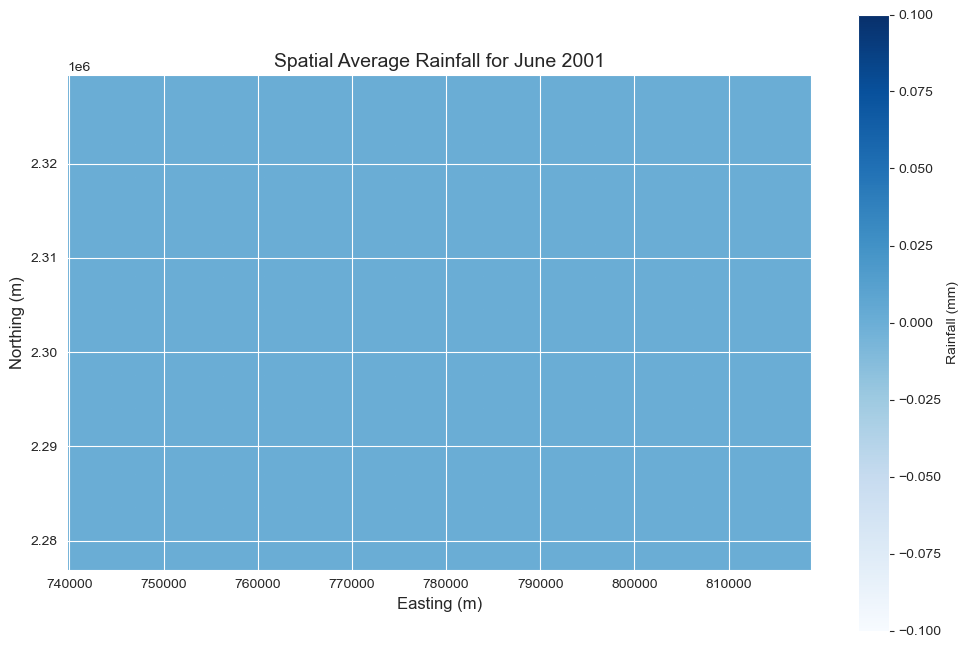

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Extract rainfall data for a specific time range (e.g., January 2001)
rainfall_june_2001 = rainfall_data.sel(time=slice("2001-06-01", "2001-06-30"))

# Compute daily average rainfall over the entire region
daily_avg_rainfall = rainfall_june_2001["rainfall"].mean(dim=("x", "y"))

# Compute spatial average rainfall for January 2001
june_avg_rainfall = rainfall_june_2001["rainfall"].mean(dim="time")

# Plotting daily average rainfall as a time series
plt.figure(figsize=(10, 6))
plt.plot(daily_avg_rainfall.time, daily_avg_rainfall, marker='o', linestyle='-', label="Daily Avg Rainfall")
plt.title("Daily Average Rainfall for June 2001", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Rainfall (mm)", fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

# Plotting spatial average rainfall as a heatmap
plt.figure(figsize=(12, 8))
plt.imshow(june_avg_rainfall, origin="lower", cmap="Blues", extent=[
    rainfall_data.x.min(), rainfall_data.x.max(),
    rainfall_data.y.min(), rainfall_data.y.max()
])
plt.colorbar(label="Rainfall (mm)")
plt.title("Spatial Average Rainfall for June 2001", fontsize=14)
plt.xlabel("Easting (m)", fontsize=12)
plt.ylabel("Northing (m)", fontsize=12)
plt.show()
